/home/benjamin/git/swiss-river-network


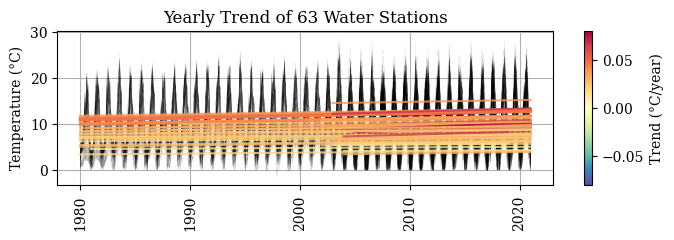

   Station     slope   intercept        r2
0     2091  0.042007  -71.707635  0.566956
1     2143  0.044053  -76.289085  0.588292
2     2016  0.045275  -78.538843  0.632990
3     2018  0.044985  -78.104441  0.579328
4     2243  0.044290  -76.226997  0.548170
..     ...       ...         ...       ...
58    2612  0.064902 -122.694733  0.469182
59    2347  0.022432  -39.114993  0.147831
60    2462  0.012328  -19.783725  0.326192
61    2617  0.016297  -27.066131  0.204268
62    2256  0.029523  -55.650914  0.681553

[63 rows x 4 columns]


In [ ]:
# Magic home
%cd /home/benjamin/git/swiss-river-network-benchmark/


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.dates as mdates
import pandas as pd


from sklearn.linear_model import LinearRegression

from swissrivernetwork.reader.water_reader import RawBafuReaderFactory
from swissrivernetwork.benchmark.train_isolated_station import read_csv_train, read_stations

# Variables
GRAPH_NAME = ['swiss-1990', 'swiss-2010', 'zurich'][1]
EXPORT_PGF = False
EXPORT_PNG = True

# Setup PGF:
if EXPORT_PGF:
    mpl.use("pgf")

    # Optional: Configure fonts to match LaTeX document
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",  # or xelatex, lualatex
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    })

if EXPORT_PNG:
    plt.rcParams['font.family'] = 'serif'

def show(filename):
    if EXPORT_PGF:
        plt.savefig(f"swissrivernetwork/journal/visualize_results/figures/{filename}", dpi=300, bbox_inches='tight')
    elif EXPORT_PNG:
        plt.savefig(f"swissrivernetwork/journal/visualize_results/figures/{filename}", dpi=300, bbox_inches='tight')
        plt.show()
    else:        
        plt.show()

plt.figure(figsize=(8, 2))
trend_results = {}
stations = read_stations(GRAPH_NAME)

norm = plt.Normalize(-0.08, 0.08)
cmap = plt.cm.Spectral_r

for station in stations:
    wt_reader = RawBafuReaderFactory.create_water_temperature_alltime_reader()
    wts = wt_reader[station]
    #print(wts)
    #wts.info()

    df = wts[['epoch_day', 'Wert']].copy()
    df['date'] = pd.to_datetime(df['epoch_day'], unit='D', origin='unix')
    df['year'] = df['date'].dt.year

    #df = df[df['year'] < 2019]

    df['year_continuous'] = 1970 + (df['epoch_day'] / 365)

    # Plot input data
    plt.plot(df['year_continuous'], df['Wert'], c='k', linewidth=0.05, alpha=0.4)

    # Aggregate by year:
    agg = df.groupby('year').agg(['mean', 'count'])

    df = agg.xs('mean', axis=1, level=1).where(
        agg.xs('count', axis=1, level=1) > 360
    )    
    df.dropna(how='any', inplace=True)

    

    # Compute trends
    X = np.array(df.index).reshape(-1, 1)
    y = df[f'Wert'].values

    # first derivative
    #X = X[1:]
    #y = y[1:] - y[:-1]

    # Scatter plot the input data:
#    plt.plot(X, y, c='k', linewidth=0.5, alpha=0.4)


    model = LinearRegression().fit(X, y)

    slope = model.coef_[0] # C per year
    intercept = model.intercept_
    r2 = model.score(X, y)

    trend_results[station] = {
        'slope': slope,
        'intercept': intercept,
        'r2': r2        
    }
        
    #plt.plot(df.index, y, 'o-', label='Annual Avg')


    X = np.append(X, X[-1]+1).reshape(-1, 1)
    plt.plot(X, model.predict(X), color=cmap(norm(slope)), label=f'Trend ({slope:.3f} °C/year)', alpha=0.8, zorder=10)

# add the colorbar:
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Needed only to satisfy colorbar requirements
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Trend (°C/year)')  # Label for the colorbar

plt.title(f'Yearly Trend of {len(trend_results)} Water Stations')        
#plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
#plt.legend()
plt.grid(True)

# Set major ticks to yearly
#ax = plt.gca()
#ax.xaxis.set_major_locator(mdates.YearLocator())      # major ticks every year
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format ticks as year (e.g., 2020)

plt.xticks(rotation=90)


#plt.show()
show('figure_yearly_trend.png')

# Convert dictionary to DataFrame
df_trend = pd.DataFrame.from_dict(trend_results, orient='index')
df_trend.index.name = 'Station'
df_trend.reset_index(inplace=True)

print(df_trend)
#print(trend_results)

    

    









In [10]:
# filter by importance:
df = df_trend[df_trend['r2'] > 0.5]

print('min, max, median', df['slope'].min(), df['slope'].max(), df['slope'].median())

min, max, median 0.019265974601679246 0.08462184015189989 0.040420095653845446


In [11]:
# Load the data
#df = read_csv_train(GRAPH_NAME)
#df['year'] = 1970 + df['epoch_day'] // 365
#df['date'] = pd.to_datetime(df['epoch_day'], unit='D', origin='unix')
#df['year'] = df['date'].dt.year

stations = read_stations(graph_name)

df_grouped = df.groupby('year').size()
print(df_grouped)

# WTF
#df_wt = df.filter(regex='_wt$')
#df_wt[['2473_wt']].plot()

#plt.figure()
#plt.plot(df['year'], df['2473_wt'])

# Yearly Average per Station
#df = df.groupby('year').mean()
#df = df.drop(columns=['epoch_day', 'has_nan'])
#print(df)

# Split into wt and at:
#df_wt = df.filter(regex='_wt$')
#df_at = df.filter(regex='_at$')





'''
# Plot with trend line
plt.figure(figsize=(8, 4))
plt.plot(df.index, y, 'o-', label='Annual Avg')
plt.plot(df.index, model.predict(X), 'r--', label=f'Trend ({slope:.3f} °C/year)')
plt.title(f'{station} - Yearly Trend')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()
'''

# Visualize
#f_at.plot(figsize=(12, 6), marker='o')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Line Plot")
plt.grid(True)
plt.legend(title="Stations")  # optional
plt.tight_layout()
plt.show()


NameError: name 'graph_name' is not defined